# Attempting to extract params from multi-layered samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor, LayeredExtractorNK
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractorNKD

[((3.46+0.01j), 0.0005), ((2.5+0.015j), 0.00025)]


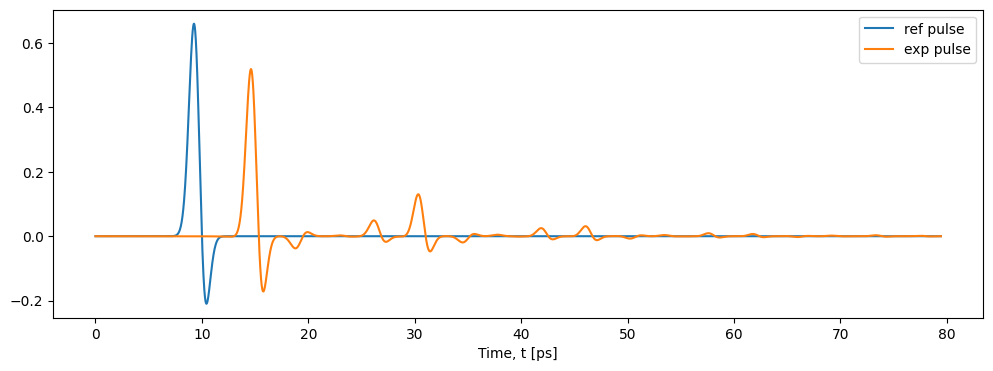

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 0.5e-3
n2, k2, d2= 2.5, 0.015, 0.25e-3

#[((3.4166622161865234+0.012177780270576477j), 0.0010128056164830923), ((2.5609753131866455+0.010933149605989456j), 0.0004871061537414789)]
#

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Test General model to fit all 3 parameters

Starting Bayesian Optimization for n, k, and D...
Search Boundaries:
Layer 1: n ∈ (3.34, 3.54), k ∈ (0.004999999999999999, 0.025), D ∈ (0.00045, 0.0007499999999999999)
Layer 2: n ∈ (2.31, 2.5100000000000002), k ∈ (0.007000000000000001, 0.027000000000000003), D ∈ (0.00015, 0.00045)
Bayesian Optimization complete.
[((3.34+0.004999999999999999j), 0.000545332352411785), ((2.372557540714448+0.027000000000000003j), 0.00023698305626480428)]


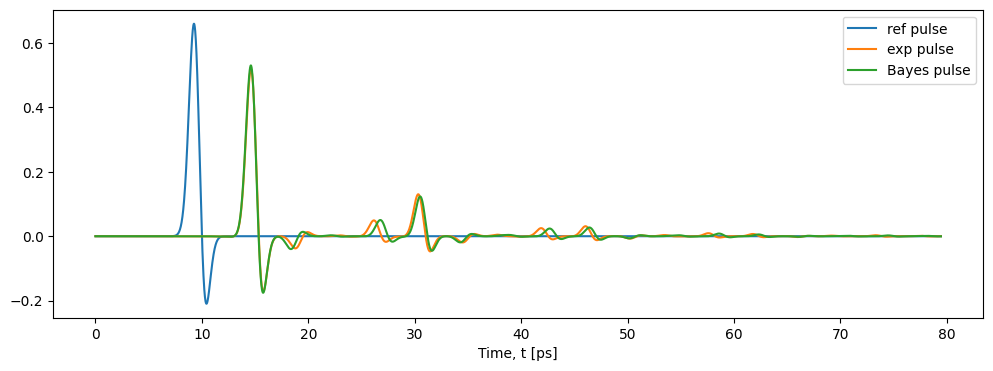

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_init = [(3.44+1j*0.015, 0.6e-3), (2.45+1j*0.017, 0.3e-3)]

Bayesian_optimizer = BayesianLayeredExtractorNKD(reference_pulse, experimental_pulse, deltat, layers_init)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Optimizing for 100 iterations with loss multiplier 1.
Iteration 4, Loss: 0.009309707209467888, Layer 0: n=3.3435585498809814, k=-0.0004061239305883646, D=0.0005445051938295364, Layer 1: n=2.384894847869873, k=0.023824995383620262, D=0.0002384041581535712
Iteration 9, Loss: 0.00827737431973219, Layer 0: n=3.33868145942688, k=-0.0028687280137091875, D=0.0005378544447012246, Layer 1: n=2.3954925537109375, k=0.02956068143248558, D=0.0002382411912549287
Iteration 14, Loss: 0.006904516369104385, Layer 0: n=3.3439700603485107, k=-0.005705411080271006, D=0.0005357314366847277, Layer 1: n=2.4170618057250977, k=0.0334792397916317, D=0.00024067806953098625
Iteration 19, Loss: 0.005699471104890108, Layer 0: n=3.3480560779571533, k=-0.0038396900054067373, D=0.0005321187782101333, Layer 1: n=2.439059019088745, k=0.042172450572252274, D=0.00024293034221045673
Iteration 24, Loss: 0.004937595222145319, Layer 0: n=3.35042667388916, k=-0.005810149013996124, D=0.000526574847754091, Layer 1: n=2.4601755142

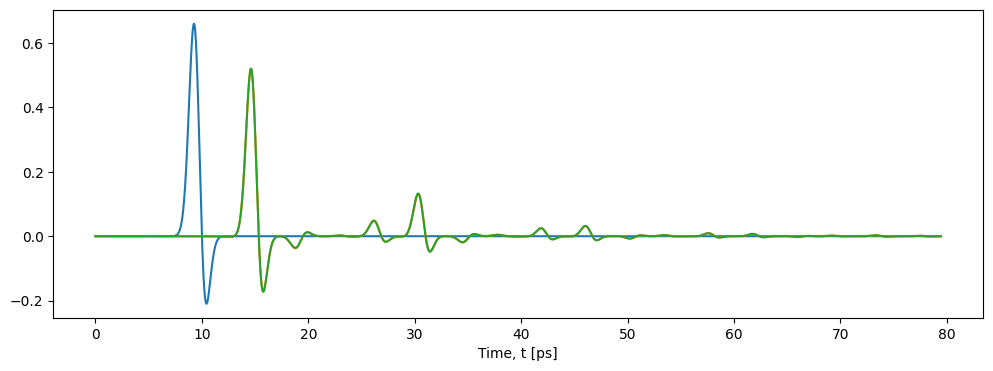

In [4]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.01)
nj,kj,dj = LE.optimize(num_iterations=100, updates=5 , alpha=1)

optim_params = [(nj[0]+1j*kj[0], dj[0]), (nj[1]+1j*kj[1], dj[1])]

_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.show()

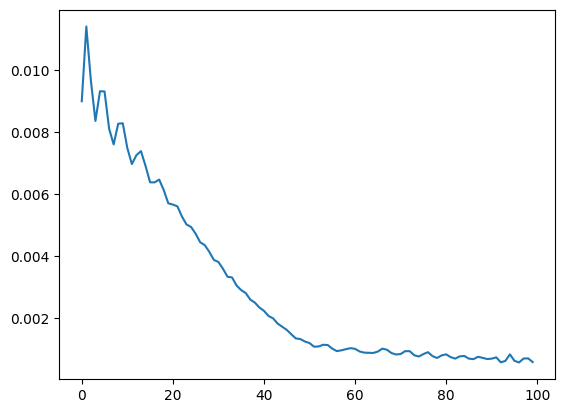

In [5]:
plt.plot(LE.loss_history)

In [6]:
# Conclusion here is that more data may be needed to optimize all 3 parameters for multiple layers
# Longer time domain sample required